## ERROR review: Wessel et al., 2016

by Russ Poldrack, March 18, 2024

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency



### Data loading and preparation

Load the data from the spreadsheet shared at http://www2.psychology.uiowa.edu/faculty/wessel/gonogo.xlsx

In [3]:
data = pd.read_excel('http://www2.psychology.uiowa.edu/faculty/wessel/gonogo.xlsx')

In [4]:
data.head()

,First Author,Experiment,Year,PMID,Journal,First word of title,p(nogo),SOA (ms),"SOA (ms, max)",Method,Comments
0,Eimer,1,1993,8507742,Biological Psychology,Effects,25.0,3000,3000,EEG,NaN
1,Eimer,2,1993,8507742,Biological Psychology,Effects,50.0,3000,3000,EEG,NaN
2,Kopp,1,1996,8758967,Electroencephalogr Clin Neurophysiol,N2,33.0,2650,2650,EEG,NaN
3,Shibata,1,1999,10211765,Neuroscience Research,Event-related,50.0,3520,5520,EEG,NaN
4,Kroner,1,1999,10463312,Psychopharmacology,Effects,50.0,1550,2050,EEG,NaN


In [4]:
data.shape

(241, 11)

### Coding analysis

The goal here is to doublecheck the coding of the relevant variables (pnogo, soa, and max soa) from the original papers.  We will do this on a randomly selected subset of 10% of the papers in the original set.

Process for recoding:
- select a random subset of papers, ensuring that there are no repeats in the set (since some papers appeared more than once)
- remove the values for recoding, to avoid bias
- save these to a csv file, and then convert to excel (renaming to recoded_papers.xlsx to prevent accidentally overrwriting if this notebooks is rerun)

I also pulled out a non-overlapping sample of 5 articles for practice, so that I could get some practice in coding by comparison to the authors' values before moving on to blind coding of the target sample.

In [75]:
random_seed = 42

# Sample from the DataFrame
sample_df_full = data.sample(n=round(data.shape[0] * .1), random_state=random_seed)
sample_df = sample_df_full.copy()

# Make sure there are no repeated pmids
assert sample_df.shape[0] == sample_df.PMID.nunique()

# remove the relevant values
sample_df['p(nogo)'] = None
sample_df['SOA (ms)'] = None
sample_df['SOA (ms, max)'] = None

# save to CSV
sample_df.to_csv('sample_df.csv', index=False)


# get another sample for practice

random_seed = 12
# Sample from the DataFrame
practice_df = data.sample(n=5, random_state=random_seed)

# Make sure there are no repeated pmids
assert practice_df.shape[0] == practice_df.PMID.nunique()

overlap = set(sample_df.PMID).intersection(set(practice_df.PMID))
assert len(overlap) == 0

# save to CSV
practice_df.to_csv('practice_df.csv', index=False)

# do this for comparison below
sample_df_full.set_index('PMID', inplace=True)



Load the recoded values and compare to the author's values

In [76]:

recoded_df = pd.read_excel('recoded_papers.xlsx')[['PMID', 'p(nogo)', 'SOA (ms)', 'SOA (ms, max)']]
recoded_df.set_index('PMID', inplace=True)

assert recoded_df.index.tolist() == sample_df_full.index.tolist()

combined_df = sample_df_full[['First Author', 'Year', 'p(nogo)', 'SOA (ms)', 'SOA (ms, max)']].merge(recoded_df, left_index=True, right_index=True, suffixes=('_original', '_recoded'))


Find mismatching values

In [77]:
combined_df[combined_df['p(nogo)_original'] != combined_df['p(nogo)_recoded']]

,First Author,Year,p(nogo)_original,SOA (ms)_original,"SOA (ms, max)_original",p(nogo)_recoded,SOA (ms)_recoded,"SOA (ms, max)_recoded"
PMID,,,,,,,,
24806263,Zhang,2014,50.0,1300,1500,40.0,1300,1500
16766210,Arce,2006,32.0,1700,1700,31.7,1700,1700
12498755,Garavan,2002,6.8,1000,1000,6.3,1000,1000
14568482,Garavan,2003,6.8,1000,1000,10.4,1000,1000


p(nogo) mismatches:

#### 24806263(Zhang):

> The task contained 200 stimuli (60% Go and 40% NoGo) in random order.

Original specified this as 50%

Verdict: minor error

#### 16766210(Arce):

> The stimuli consist of large circles (n = 64), small circles (n = 16), large squares (n = 43), and small squares (n = 57). Each stimulus appears for 200 ms. Subjects are instructed to press a button each time a large circle, small circle, or large square appears (go), and not to press the button when a small square is shown (Nogo).

57 / (64 + 16 + 43 + 57) = 0.316  

Original specified this as 32%. This could be considered a rounding difference, but other studies have p(nogo) specified to the first decimal point

Verdict: minor error.


#### 12498755(Garavan):

> During fMRI scanning, subjects completed four runs that contained 1180 targets (GO stimuli) and 80 lures (NOGO stimuli)

80/(80 + 1180) = .063

Original specified this as 6.8%.

Verdict: minor error


#### 14568482(Garavan):

> There were 448 GO and 52 NOGO stimuli presented in each conflict condition

52/(448 + 52) = 0.104

Original specified as 6.8%.

Verdict: minor error

In [101]:
# get range of errors:

(combined_df['p(nogo)_original'] - combined_df['p(nogo)_recoded']).value_counts().sort_index()


-3.6      1
 0.0     20
 0.3      1
 0.5      1
 10.0     1
dtype: int64

In [92]:
min_mismatch = combined_df[combined_df['SOA (ms)_original'] != combined_df['SOA (ms)_recoded']]
max_mismatch = combined_df[combined_df['SOA (ms, max)_original'] != combined_df['SOA (ms, max)_recoded']]
soa_mismatch = pd.concat([min_mismatch, max_mismatch]).drop_duplicates()
soa_mismatch


,First Author,Year,p(nogo)_original,SOA (ms)_original,"SOA (ms, max)_original",p(nogo)_recoded,SOA (ms)_recoded,"SOA (ms, max)_recoded"
PMID,,,,,,,,
25132537,Stock,2016,30.0,3100,3500,30.0,900,2200
26843358,Cheng,2016,20.0,1050,1250,20.0,1000,1200
23764434,Hagenhoff,2013,25.0,4050,4050,25.0,50,4000
26093649,Grunewald,2015,30.0,2000,2000,30.0,1500,2000
24389161,Tolin,2014,15.0,1050,1050,15.0,1000,2000
18164657,Smith,2008,20.0,4500,5500,20.0,4700,5700
15826845,Kamarajan,2005,50.0,1900,1900,50.0,1550,2100
20640552,Dirnberger,2010,50.0,7900,10400,50.0,7500,10000
19188005,Baglio,2011,20.0,2350,6570,20.0,2350,6750


SOA mismatches:

#### 25132537         Stock

> Each trial started with a 200-ms presentation of the target stimulus followed by a centrally presented white fixation cross. The trials either ended with the first response or after 2200 ms (if no response was made). The inter-trial interval consisted of a white fixation cross presented in
the center of the screen and varied randomly between 700 and 1100 ms to avoid effects of expectancy/time estimation.

I coded this as 900 minimum SOA (200 ms presentation + 700 ms minimum ITI)
IT seems that the 3100 ms original estimate must have been based on 2200 + 200 + 700 which assumes that the 2200 ms window did not include the 200 ms presentation time, which seems unlikely to be but unclear.  It's also likely that the minimum was shorter since mean RTs were less than 400 ms.
Similarly, the original 3500 ms estimate for max ISI was likely based on 2200 + 200 + 1100, which seems like a correct max except that the 200 ms presentation time probably should not have been included (but unclear).

Verdict: indeterminate due to lack of clarity in the paper


#### 26843358         Cheng

> In the somatosensory-driven Go-Nogo task, stimuli (0.2 ms square wave current) were delivered to the second or fifth digit of the left hand. The stimulus intensity was 2.5 times the sensory threshold39. The anode was placed at the distal interphalangeal joint and the cathode at the proximal interphalangeal joint of the corresponding digit. Subjects were instructed to press the button with their right hand to stimuli on the left second digit (Go, 80%) as quickly and accurately as possible, and to withhold the responses to stimuli on the left fifth digit (Nogo, 20%). The ISIs varied between 1.0 and 1.2 s. In the auditory-driven Go-Nogo task, the stimuli were delivered binaurally with 50 ms-duration sine-wave tones. Subjects were instructed to press the button with their right hand to the frequent low-pitched (800 Hz) tones (Go, 80%) as quickly and accurately as possible, and to withhold the responses to the infrequent high-pitched (850 Hz) tones (Nogo, 20%). The ISI also varied between 1.0 and 1.2 s, and the sound intensity was around 70 dB above the individual’s hearing threshold.

I coded this based on the somatosensory task, which didn't specify the duration of the stimulus so I assumed that it was subsumed in the ISI.  However, the original coding is correct for the Auditory task assuming that the ISI started at  the stimulus offset.

Verdict: no error


#### 23764434     Hagenhoff

> In all tasks, two types of visual stimuli (30 triangles, 30 squares; stimulus presentation 50 ms) were presented in pseudo-random order on a computer screen. Subjects had to indicate their response by moving a cursor as fast as possible from a starting button to a corresponding target button, using pen movements on a graphic tablet. The starting and target buttons were displayed on the computer screen. Trials were self-paced, with subjects signalling the start of a trial by positioning the cursor at the starting button (see supplementary material Fig. S1). Responses had to be initiated within 4 s after stimulus onset. Slower reaction times were processed as errors. Each task was preceded by a practice session.

I coded this as 4000 max, assuming that the stimulus presentation was part of the 4000 ms response window.  I coded the min as 50 ms, realizing that this is not realistic since RTs will be longer than 50 ms.  

Verdict: indeterminate due to lack of clarity in the paper


#### 19188005        Baglio

> The duration of each trial was 150 ms; the interstimulus inter- val was pseudorandomly assigned, ranging from 2.2 to 6.6 s.

I coded max SOA as 6750, original coded it as 6570, presumably a typo.

Verdcict: minor error


#### 26093649	Grunewald

> [Stimuli] were presented on a computer screen (visual angle: vertical 10°, horizontal 7°, resolution 1280 9 1024) on a black background until there was a mouse click or for a maximum of 500 ms. The inter- stimulus interval (showing a white fixation cross) was 1500 ms.

I coded as (1500, 2000) which is clearly not realistic.  Original coded as (2000, 2000), which is reasonable given that mean RT's were in the 400-500 ms range.

Verdict: no error


#### 24389161         Tolin

> The task consisted of frequent `X' (P = 0.85) and infrequent `K' (P = 0.15) stimuli presented at 3 × 5 visual degrees for 50 ms each. The minimum interstimulus interval was 1000 ms. 

I coded as (1000, 2000), assuming that the 1000 ms response window was additive to the 1000 ms ISI.  Original coded it as (1050, 1050), assuming that the SOA was defined by the stimulus duration plus the stimulus duration.

Verdict: Indeterminate due to lack of clarity in the paper


#### 18164657         Smith

> In each trial, a 1500 Hz warning tone1 was followed 1500 ms later by one of three tones: a 750 Hz tone (pre- sented on 60% of trials), a 1000 Hz tone (20% of trials) or a 2000 Hz tone (20% of trials). Thus, the Go tones were always lower, and the NoGo tone always higher than the warning stimulus. There was then a variable interval (3.0–4.0 s, 3.5 s mean) until the next warning stimulus. All stimuli were binaurally presented through headphones at 70 dB SPL for 200 ms (40 ms rise and fall time), with no two 2000 Hz trials occurring in succession.

I coded as (4700, 5700) based on 1500 ms initial period followed by a 200 ms tone followed by 3-4 s interval.   Original coded as (4500, 5500), which fails to include the 200 ms target tone. 

Verdict: minor error


#### 15826845     Kamarajan

No details regarding the stimulus timing were present in this paper. Instead, it stated:

> The experimental paradigm is identical to our previous studies (Kamarajan et al., 2004, in press).

I looked up the 2004 reference: Kamarajan C, Porjesz B, Jones KA, Choi K, Chorlian DB, Padmanabhapillai A, Rangaswamy M, Stimus AT, Begleiter H. The role of brain oscillations as functional correlates of cognitive systems: a study of frontal inhibitory control in alcoholism. Int J Psychophysiol. 2004; 51:155– 180. [PubMed: 14693365]

> The inter-trial intervals (ITI) for the Go trials with and without Dollar sign (i.e., correct and incorrect Go trials) were 2100 msec and 1550 msec respectively, while the ITI for the No-go trials was 1550 msec (as the Dollar sign never appeared in the No-go trials). 

The same detail was also present in the paper referred to as "in press".

I coded as (1550, 2100).  Original coded as (1900, 1900).

Verdict: minor error


#### 20640552    Dirnberger

> A medium frequency warning tone (1,000 Hz, 200 ms) was first presented via a loudspeaker, and followed exactly 2 s later by an imperative stimulus consisting of either a high frequency (1,500 Hz, 200 ms) or low frequency tone (500 Hz, 200 ms) representing Go and NoGo signals, respectively. ... The interval between the imperative stimulus of the present trial and the warning stimulus for the subsequent trial varied randomly from 5.5 to 8.0 s. 

I coded as (7500, 10000).  Original coded as (7900, 10400).

Verdict: Indeterminate due to lack of clarity in the paper.



In [99]:
# get range of errors:

(combined_df['SOA (ms)_original'] - combined_df['SOA (ms)_recoded']).value_counts().sort_index()


-200      1
 0       16
 50       2
 350      1
 400      1
 500      1
 2200     1
 4000     1
dtype: int64

In [100]:
(combined_df['SOA (ms, max)_original'] - combined_df['SOA (ms, max)_recoded']).value_counts().sort_index()


-950      1
-200      2
-180      1
 0       16
 50       2
 400      1
 1300     1
dtype: int64

### Data analysis

The main goal here is to attempt to recreate the figures from the provided data.

In [5]:
# create variable for proportion of nogo trials
data['pnogo'] = data['p(nogo)'] / 100

# replace values for "Other" methods for figure 2 below
methods_to_plot = ['EEG', 'fMRI', 'Behavioral']
# harmonize the various different codes for "Behavioral" methods
data['Method'] = data['Method'].replace({'Behav': 'Behavioral', 'Behavior': 'Behavioral'})
for i in data.index:
    if data.loc[i, 'Method'] not in methods_to_plot:
        data.loc[i, 'Method'] = 'Other'

data.Method.value_counts()

EEG           115
fMRI           77
Behavioral     31
Other          18
Name: Method, dtype: int64

### Figure 1: Bottom left panel

Attempt to recreate Figure 1, at least roughly.  The figures may look slightly different due to differences in histogram binning; I'm primarily checking for rough agreeement in the patterns.

> Overview of the go/no-go literature (241 experiments published between 1993 and 2016). Bottom left: Heat map of the distribu- tion of the two parameters’ trial duration (x axis) and p(nogo) (y axis).
For each study, trial duration is plotted as a range between the minimal and maximal duration between two subsequent stimuli on each trial of the experiment. Exception: experiments in which trial duration was fixed
(i.e., minimum and maximum trial duration were the same, a 50-ms artifi- cial “buffer” was added so that the data point is easier to see). For example, the one experiment that used a p(nogo) of .6 (top left of the heat map) had a fixed trial duration of 1,000 ms, which was spread out to 950–1,050 ms for the purposes of this heat map.


This is not exactly clear: "if a task used a range of trial durations, that entire range was plotted"

First pass: create a matrix with bins for duration, and then set all bins between the min and max for an experiment equal to 1 for the particular study.  for studies with a single duration, use this strategy: "experiments in which trial duration was fixed
(i.e., minimum and maximum trial duration were the same, a 50-ms artifi- cial “buffer” was added so that the data point is easier to see). For example, the one experiment that used a p(nogo) of .6 (top left of the heat map) had a fixed trial duration of 1,000 ms, which was spread out to 950–1,050 ms for the purposes of this heat map. "

In [6]:
binsize = .1 # secs
duration_bins = np.arange(0, 18.1, binsize)
data['duration'] = np.nan

studybins = np.zeros((data.shape[0], len(duration_bins)))
pnogo = np.zeros(data.shape[0])

for i, idx in enumerate(data.index):
    bin_idx = np.zeros(len(duration_bins))
    min_soa = data.at[idx, 'SOA (ms)']/1000
    max_soa = data.at[idx, 'SOA (ms, max)']/1000
    if min_soa == max_soa:
        min_soa -= .05
        max_soa += .05
    data.at[idx, 'duration'] = max_soa
    bin_idx[(duration_bins >= min_soa) & (duration_bins <= max_soa)] = 1

    studybins[i, :] = bin_idx
    pnogo[i] = data.at[idx, 'pnogo']


Now combine across studies within each p(nogo) bin

In [7]:
nogo_binsize = .01
nogo_bins = np.arange(0.01, 0.65, nogo_binsize)

nogo_studybins = np.zeros((len(nogo_bins), studybins.shape[1]))

for i in range(studybins.shape[0]):
    # find closest study bin value
    closest = np.argmin(np.abs(nogo_bins - pnogo[i]))
    nogo_studybins[closest, :] += studybins[i, :]

Text(0, 0.5, 'P(nogo)')

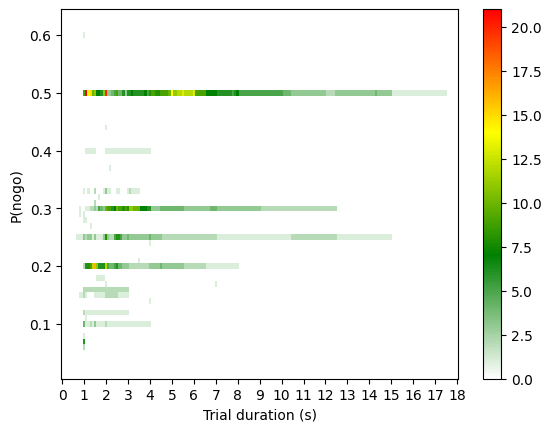

In [8]:
# Define a colormap that is similar to the one from the Wessel paper
cmap = LinearSegmentedColormap.from_list(
    "green_red", 
    ["white", "green", "yellow", "red"]
)
plt.imshow(nogo_studybins, aspect='auto', interpolation='nearest', cmap=cmap)
ytick_marks = np.arange(9, len(nogo_bins), 10).astype(int)
ytick_labels = [f'{i:.1}' for i in nogo_bins[ytick_marks]]
_ = plt.yticks(ytick_marks, ytick_labels)

xtick_marks = np.arange(0, len(duration_bins), 10).astype(int)
xtick_labels = [f'{i:.0f}' for i in duration_bins[xtick_marks]]

plt.xticks(xtick_marks, xtick_labels)
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel('Trial duration (s)')
plt.ylabel('P(nogo)')


Compare to:

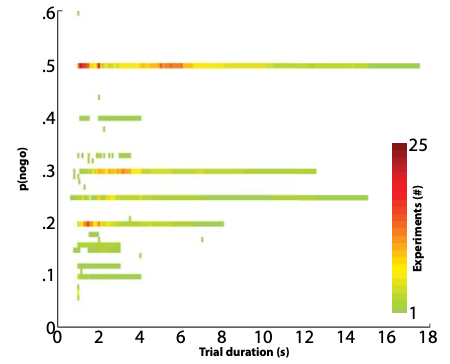

### Figure 1: Bottom right panel

> Bottom right: Histogram of the heat map’s y axis (p(nogo) parameter). 

 Here we create a binned version of the full duration X p(nogo) matrix and then plot the marginal sum.



Text(0, 0.5, 'p(nogo)')

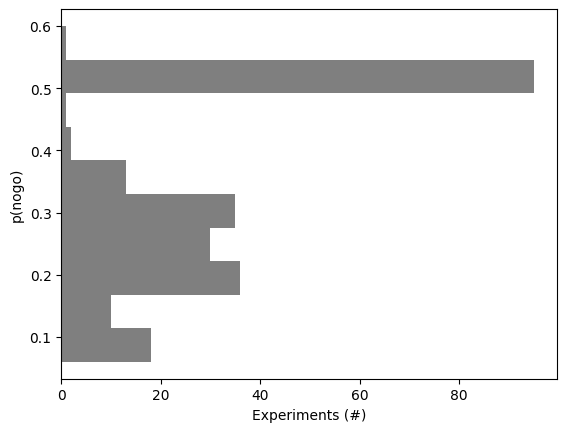

In [9]:
plt.hist(pnogo, bins=10, color='k', alpha=.5, orientation='horizontal')
plt.xlabel("Experiments (#)")
plt.ylabel("p(nogo)")

Compare to:


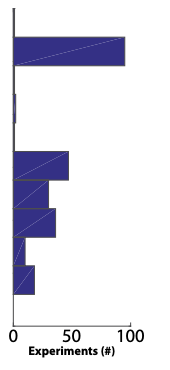

This doesn't look exactly like the original due to binning differences, but the overall pattern is preserved.

### Figure 1: Top left panel

>  Top left: Histogram of the heat map’s x axis (trial duration parameter). 


In [10]:
binsize_downsampled = 1
bins_downsampled = np.arange(0, 18.1, binsize_downsampled)

studybins_binned = np.zeros((data.shape[0], len(bins_downsampled)))

for i, bin_floor in enumerate(bins_downsampled):
    if i == len(bins_downsampled) - 1:
        break
    bin_ceil = bins_downsampled[i + 1]
    bin_cols = np.where((duration_bins >= bin_floor) & (duration_bins < bin_ceil))[0]
    bin_sums = np.sum(studybins[:, bin_cols], axis=1)
    studybins_binned[:, i] = (bin_sums > 0).astype(int)

array([[<Axes: title={'center': 'duration'}>]], dtype=object)

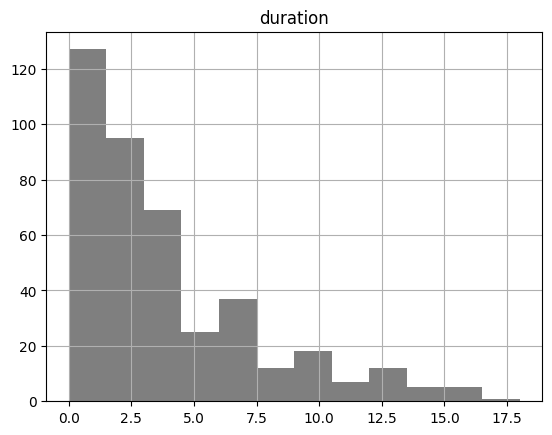

In [11]:
duration_df = pd.DataFrame({'count': studybins_binned.sum(axis=0), 'duration': bins_downsampled})
duration_df.hist(column='duration', weights=duration_df['count'], bins=12, color='k', alpha=.5)

Compare to:

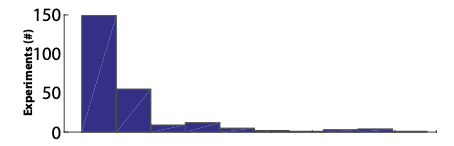

This doesn't look exactly right due to binning, but the pattern is roughly preserved.

### Figure 1: Top right panel

> since the distribution of trial durations depicted in the histogram on the top left plot has a very long and shallow right tail, the percentage of studies by trial duration was also plotted in 5 bins(<1s,1–2s,2–3s,3–4s,>4s)

Text(0.5, 0, 'Trial duration (s)')

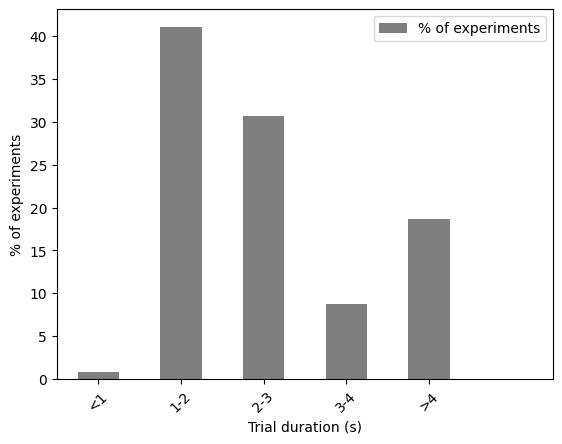

In [12]:

bins = [0, 1, 2, 3, 4, 18]
duration_hist_df = pd.DataFrame({'count': None, 'duration': bins})
for i in range(len(bins)-1):
    duration_hist_df.at[i, 'count'] = ((data['duration'] >= bins[i]) & (data['duration'] < bins[i+1])).sum()
duration_hist_df['% of experiments'] = duration_hist_df['count'] / duration_hist_df['count'].sum() * 100

duration_hist_df.plot(kind='bar', x='duration', y='% of experiments', color='k', alpha=.5)
ytick_marks = np.arange(0, len(bins)-1).astype(int)
ytick_labels = ['<1', '1-2', '2-3', '3-4', '>4']
_ = plt.xticks(ytick_marks, ytick_labels, rotation=45)
plt.ylabel('% of experiments')
plt.xlabel('Trial duration (s)')


Compare to:

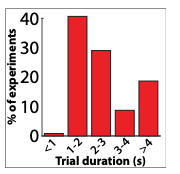

### Figure 2


> Distribution of go/no-go task parameters by publication date (upper two rows) and method of measurement (bottom two rows)

#### Figure 2A



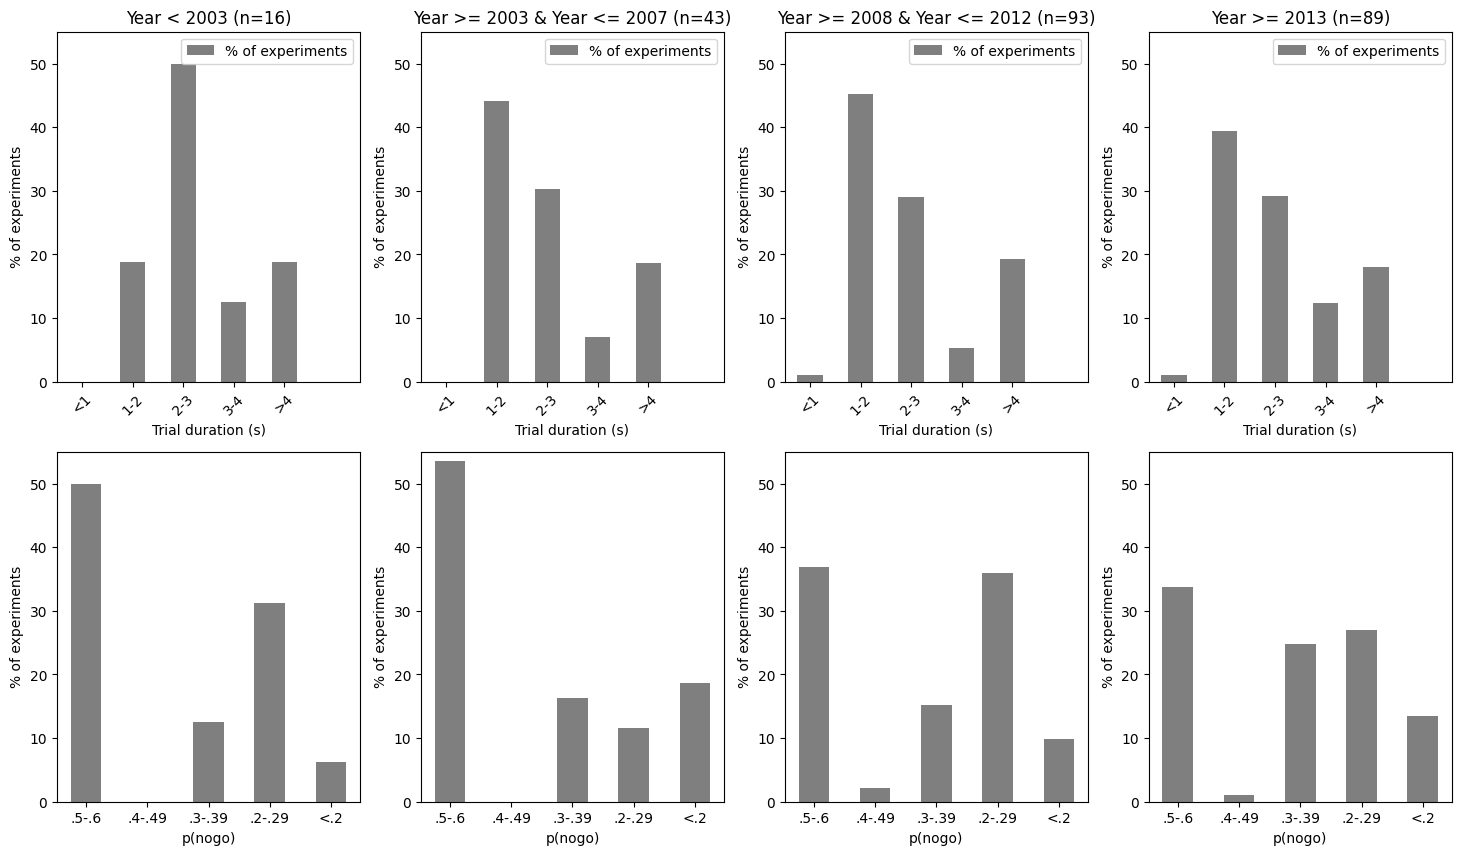

In [13]:
def plot_duration(data, bins, ax, filter=None, ylim=55):
    xtick_labels = ['<1', '1-2', '2-3', '3-4', '>4']
    bins = [0, 1, 2, 3, 4, 18]
    if filter is not None:
        df = data.query(filter)
    else:
        df = data.copy()
    duration_hist_df = pd.DataFrame({'count': None, 'duration': bins})
    for i in range(len(bins)-1):
        duration_hist_df.at[i, 'count'] = ((df['duration'] >= bins[i]) & (df['duration'] < bins[i+1])).sum()
    duration_hist_df['% of experiments'] = duration_hist_df['count'] / duration_hist_df['count'].sum() * 100

    duration_hist_df.plot(kind='bar', x='duration', y='% of experiments', color='k', alpha=.5, ax=ax)
    xtick_marks = np.arange(0, len(bins)-1).astype(int)
    _ = ax.xaxis.set_ticks(ticks=xtick_marks, labels=xtick_labels, rotation=45)
    ax.set_ylabel('% of experiments')
    ax.set_xlabel('Trial duration (s)')
    ax.set_ylim(0, ylim)
    ax.set_title(filter + ' (n=' + str(df.shape[0]) + ')')
    return duration_hist_df


def plot_nogo(data, ax, filter=None, ylim=55):

    if filter is not None:
        df = data.query(filter)
    else:
        df = data.copy()
    
 
    xtick_labels = ['.5-.6', '.4-.49', '.3-.39', '.2-.29', '<.2']
    cutoffs = [0.6, 0.5, 0.4, 0.3, 0.2, 0]
    nmatches = []
    for i in range(1, len(cutoffs)):
        nmatches.append(((df['pnogo'] >= cutoffs[i]) & (df['pnogo'] < cutoffs[i-1])).sum())
    
    pnogo_hist_df = pd.DataFrame({'nexp': nmatches, 'label': xtick_labels})
    pnogo_hist_df['pmatch'] = pnogo_hist_df['nexp'] / pnogo_hist_df['nexp'].sum() * 100
    ax.bar(pnogo_hist_df.label, pnogo_hist_df.pmatch, color='k', alpha=.5, width=.5)
    ax.set_ylabel('% of experiments')
    ax.set_xlabel('p(nogo)')
    ax.set_ylim(0, ylim)
    return pnogo_hist_df

fig, ax = plt.subplots(2, 4, figsize=(18, 10))
year_filters = ['Year < 2003', 'Year >= 2003 & Year <= 2007', 'Year >= 2008 & Year <= 2012', 'Year >= 2013']

# save results for statistical analysis below
duration_results_by_year = {}
nogo_results_by_year = {}

for i, filter in enumerate(year_filters):
    duration_results_by_year[i] = plot_duration(data, duration_bins, ax[0, i], filter=filter)
    nogo_results_by_year[i] = plot_nogo(data, ax[1, i], filter=filter)



Compare to:

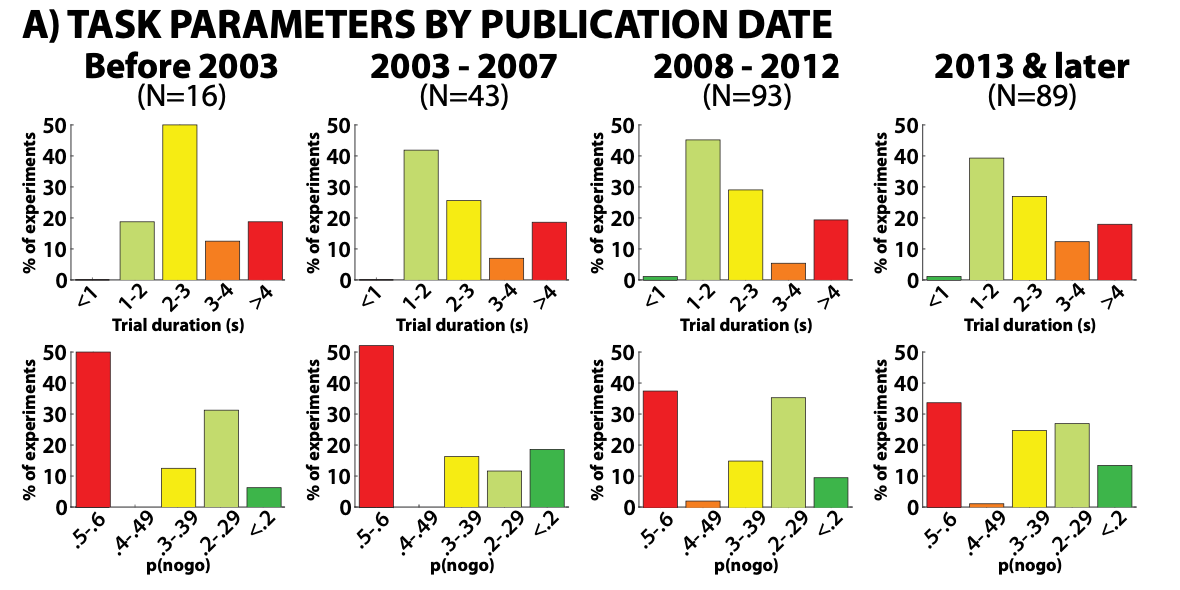


#### Figure 2B

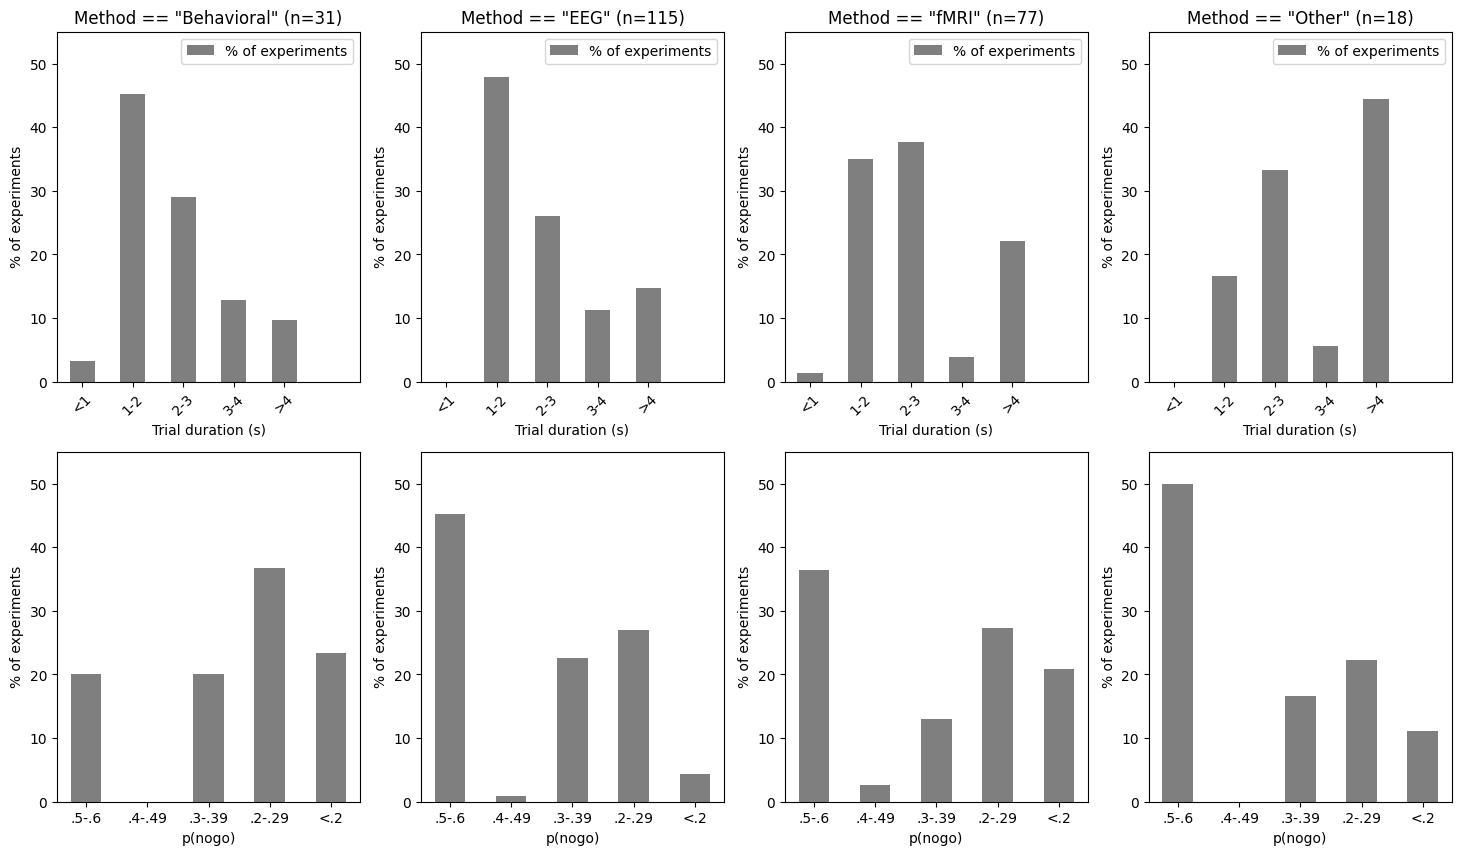

In [14]:
fig, ax = plt.subplots(2, 4, figsize=(18, 10))
filters = ['Method == "Behavioral"', 'Method == "EEG"', 'Method == "fMRI"', 'Method == "Other"']
for i, filter in enumerate(filters):
    plot_duration(data, bins, ax[0, i], filter=filter)
    plot_nogo(data, ax[1, i], filter=filter)



Compare to:


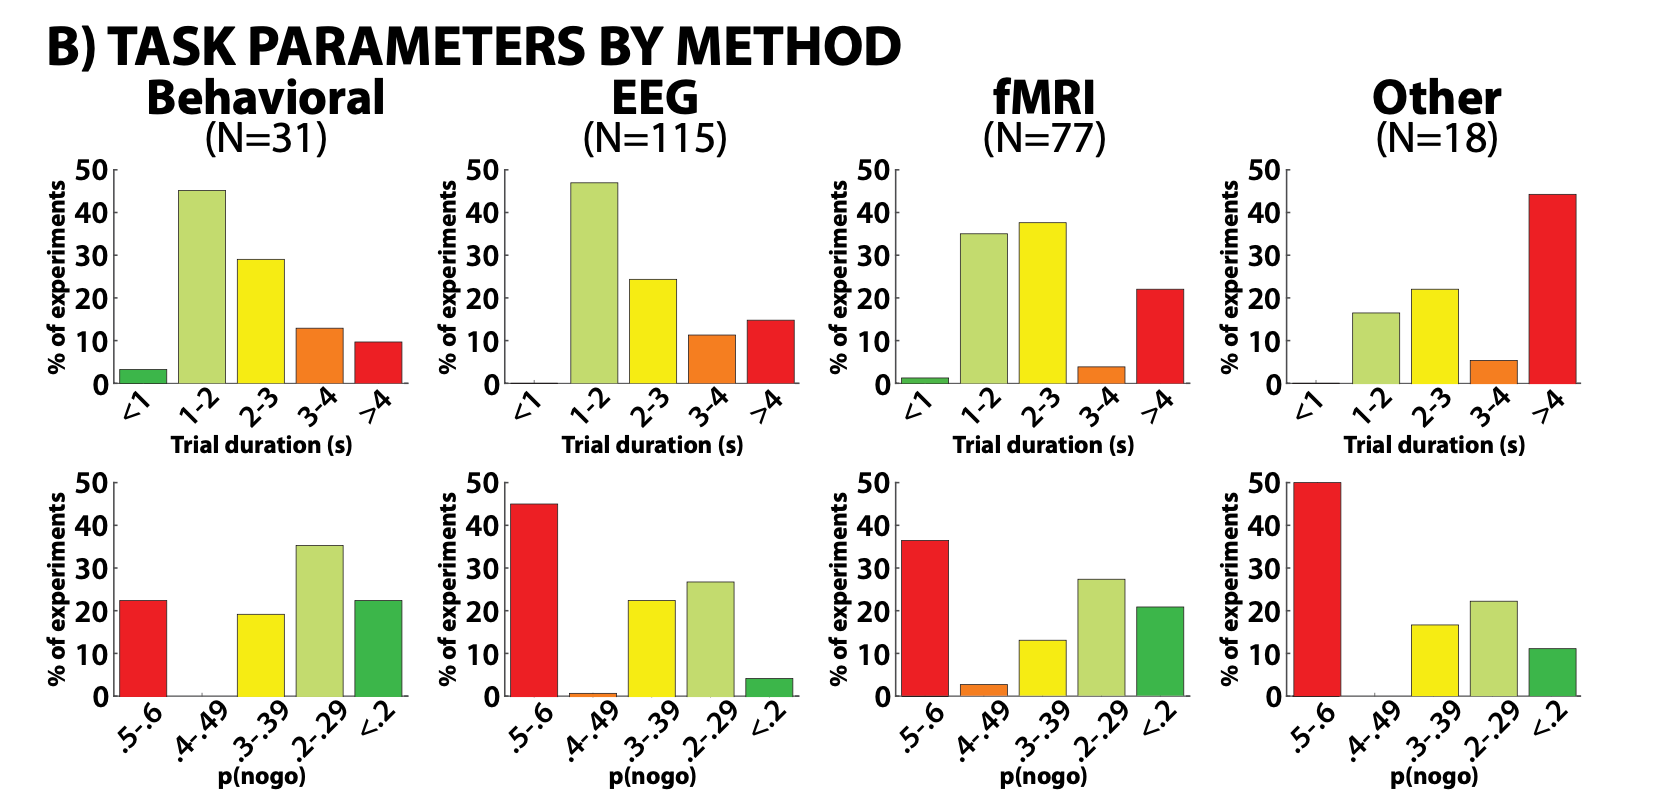

These all appear to match very well, if not exactly, to the published figure.

### Results section

> The mode for the p(nogo) parameter was .5, with a parameter range of .06 to .6. Nominally, 39.4% of all studies used equiprobable go/no-go likelihoods. For comparison, the second most common parameter was .2, used by 13.3% of all studies.

correct:

In [15]:

pnogo_counts = data['pnogo'].value_counts()/data.shape[0] * 100
print('min p nogo:', pnogo_counts.index.min())
print('max p nogo:', pnogo_counts.index.max())
print(pnogo_counts.head())


min p nogo: 0.06
max p nogo: 0.6
0.50    39.419087
0.20    13.278008
0.25    11.618257
0.30    11.618257
0.33     4.979253
Name: pnogo, dtype: float64


> The trial duration parameter had a wider range, spanning from 650 ms to 17,550 ms between successive stimuli.  

In [16]:
# print min/max for computed duration
print('min duration', data['duration'].min())
print('max duration', data['duration'].max())

# print min/max for SOA
print('min SOA', data['SOA (ms)'].min())
print('max SOA', data['SOA (ms)'].max())

# print min/max for maximum SOA
print('min maximum SOA', data['SOA (ms, max)'].min())
print('max maximum SOA', data['SOA (ms, max)'].max())


min duration 0.8500000000000001
max duration 17.5
min SOA 650
max SOA 14300
min maximum SOA 800
max maximum SOA 17500


The min duration reported in the text matches the min SOA in the data. The max duration reported in the text doesn't seem to match the max SOA; it seems that the 50 ms buffer was added to it, even though that was not a study with a fixed trial duration.





In [17]:
data.query('duration > 17')

,First Author,Experiment,Year,PMID,Journal,First word of title,p(nogo),SOA (ms),"SOA (ms, max)",Method,Comments,pnogo,duration
57,Hatem,1,2007,17475550,Clin Neurophysiol,How,50.0,12500,17500,EEG,NaN,0.5,17.5


> The mode for the maximum duration between two trials was 2,050 ms, which is 550 ms longer than the fast-paced condition we used in the current study.

In [18]:
data['SOA (ms, max)'].mode()


0    2000
Name: SOA (ms, max), dtype: int64

In [19]:
data['duration'].mode()


0    2.05
Name: duration, dtype: float64

The claim that the mode is 2050 is based on the addition of the artificial 50 ms buffer for the studies with no SOA range, and thus is not exactly a correct summary of the studies themselves. 

> A total of 18.7% of studies have maximum trial dura- tions of greater than 4,000 ms, which was the duration of tri- als in our slow condition.

In [20]:
print('percent of experiments with SOA > 4000:', np.mean(data['SOA (ms, max)'] >= 4000))

percent of experiments with SOA > 4000: 0.18672199170124482


### Discussion

> Further analysis of the literature shows that the prevalence of suboptimal task designs has not significantly changed over the last 25 years. While there does seem to be a reduction of equiprobable go/no-go tasks in the years since 2008 (following a peak during 2003–2007, where more than half of all published studies used a p(nogo) of .5), equiprobable tasks are still the most common version, even in studies published from 2013 onward, where they still account for more than 1 in every 3 studies (Figure 2).

No statistical analysis is reported to support this claim, but a chi-squared test on the prevalence across years in the selected bins is consistent with the claim (though note that the several of the cell frequencies are below the customary minimum frequency of 5):


In [21]:
# arrange data for chi-squared test
nogo_exp_array = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        nogo_exp_array[i,j] = nogo_results_by_year[j].at[i, 'nexp']

print(nogo_exp_array)

chi2, p, dof, expected = chi2_contingency(nogo_exp_array)
print('chi2:', chi2)
print('p:', p)
print('dof:', dof)

[[ 8. 23. 34. 30.]
 [ 0.  0.  2.  1.]
 [ 2.  7. 14. 22.]
 [ 5.  5. 33. 24.]
 [ 1.  8.  9. 12.]]
chi2: 16.28749760610669
p: 0.17842013842537713
dof: 12


> Fur- thermore, the usage of slow-paced trial timings appears to be steady over the years, with 1 in every 5–6 studies using trial durations in excess of 4 s. If the parameters of the current study can serve as a comparison, fewer than 1 in every 10 studies overall (8.7%, N = 21) used both fast trial durations (<= 1,500 ms) and rare no-go stimuli, p(nogo) <= .2.

No statistical analysis is reported to support the claim that the timing is steady across years, but a chi-squared analysis is consistent with the claim (again with the caveat of some very low cell frequencies):

In [22]:
# arrange data for chi-squared test
duration_exp_array = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        duration_exp_array[i,j] = duration_results_by_year[j].at[i, 'count']
print(duration_exp_array)

chi2, p, dof, expected = chi2_contingency(duration_exp_array)
print('chi2:', chi2)
print('p:', p)
print('dof:', dof)

[[ 0.  0.  1.  1.]
 [ 3. 19. 42. 35.]
 [ 8. 13. 27. 26.]
 [ 2.  3.  5. 11.]
 [ 3.  8. 18. 16.]]
chi2: 8.233713551694871
p: 0.766610116446126
dof: 12
